# Annual Cycle

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import dask
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    height_temperature_correction,
    load_obs,
    mask_invalid,
    open_datasets,
    regional_mean,
    regional_means,
    regrid_dsets,
    select_season,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [3]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8000/status,
Dashboard: http://127.0.0.1:8000/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46049,Workers: 0
Dashboard: http://127.0.0.1:8000/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40577,Total threads: 1
Dashboard: http://127.0.0.1:39613/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:36951,


In [4]:
def compute_crco(model_ds, reference_ds):
    """
    Compute CRCO (Climatological Rank Correlation) using the direct formula.

    Formula:
        CRCO = 1 - (6 / (n*(n^2 - 1))) * sum((Rank_model - Rank_ref)^2)
        where n = 12 months

    Parameters:
    -----------
    model_ds : xarray.Dataset
        Dataset containing model data with a 'time' dimension.
    reference_ds : xarray.Dataset
        Dataset containing reference data with a 'time' dimension.
    var_name : str
        Name of the variable to compute CRCO for.

    Returns:
    --------
    crco : xarray.DataArray
        Climatological Rank Correlation at each grid point.
    """

    # Compute monthly climatology (mean over all years)
    model_clim = model_ds.groupby('time.month').mean(dim='time')
    ref_clim = reference_ds.groupby('time.month').mean(dim='time')

    n_months = 12
    factor = 6 / (n_months * (n_months**2 - 1))

    # Prepare output array with the shape of spatial dimensions
    spatial_shape = tuple(model_clim[dim].size for dim in model_clim.dims if dim != 'month')
    crco_vals = np.full(spatial_shape, np.nan)

    # List of spatial dimensions (everything except 'month')
    spatial_dims = [dim for dim in model_clim.dims if dim != 'month']

    # Loop over all grid points
    for index in np.ndindex(spatial_shape):
        # Build dictionary to index spatial dimensions
        idx_dict = {dim: i for dim, i in zip(spatial_dims, index)}

        # Select the monthly series at this grid point
        model_series = model_clim.isel(**idx_dict).data
        ref_series = ref_clim.isel(**idx_dict).data

        # Check for valid data
        if np.all(np.isfinite(model_series)) and np.all(np.isfinite(ref_series)):
            # Compute ranks
            rank_model = rankdata(model_series)
            rank_ref = rankdata(ref_series)

            # Apply formula
            d = rank_model - rank_ref
            crco_vals[index] = 1 - factor * np.sum(d**2)

    # Build xarray.DataArray with original coordinates
    coords = {dim: model_clim[dim] for dim in spatial_dims}
    crco = xr.DataArray(crco_vals, dims=spatial_dims, coords=coords, name='CRCO')
    crco['abbrevs'] = model_ds['abbrevs']

    return crco

In [5]:
from scipy.stats import rankdata

def ensure_uniform_cftime(ds):
    """Asegura que las fechas en el Dataset tengan un tipo uniforme de cftime."""
    time_vals = ds.time.values
    types = {type(t) for t in time_vals}

    if len(types) > 1:
        # Usamos el tipo del primer elemento para reconstruir todos
        base_type = type(time_vals[0])
        uniform_time = [
            base_type(t.year, t.month, t.day, t.hour, t.minute, t.second)
            for t in time_vals
        ]
        ds["time"] = ("time", uniform_time)

    return ds

def compute_roya(model_ds, reference_ds):
    """
    Compute the Ratio of Yearly Amplitude (ROYA) between a model and reference dataset.

    Parameters:
    -----------
    model_ds : xarray.Dataset
        Dataset containing model data with a 'time' dimension.
    reference_ds : xarray.Dataset
        Dataset containing reference data with a 'time' dimension.
    var_name : str
        Name of the variable to compute ROYA for.

    Returns:
    --------
    roya : xarray.DataArray
        Ratio of yearly amplitude (model/reference)
    """
    if "lon" in reference_ds.coords:
        # Spatially average these mean values over the subregion
        model_mean = model_mean.mean(dim=["lat", "lon"])
        reference_mean = reference_mean.mean(dim=["lat", "lon"])

    model_ds = ensure_uniform_cftime(model_ds)
    reference_ds = ensure_uniform_cftime(reference_ds)

    M_month = model_ds.groupby("time.month").mean("time")
    R_month = reference_ds.groupby("time.month").mean("time")

    # Group by year and calculate yearly amplitude
    model_amp = M_month.max(dim = 'month')- \
                M_month.min(dim = 'month')
    
    ref_amp = R_month.max(dim = 'month') - \
              R_month.min(dim = 'month')
    
    # Compute ROYA (model amplitude / reference amplitude)
    roya = model_amp / ref_amp
    roya = roya.rename("ROYA")

    return roya

In [6]:
def compute_crco(M: xr.DataArray,
                 R: xr.DataArray,
                 time_dim: str = "time") -> xr.DataArray:
    """
    Compute CRCO between two time-series DataArrays by:
      1. Grouping by calendar month along `time_dim`,
      2. Taking the monthly mean of each field,
      3. Computing the rank-based CRCO across the 12 monthly means.

    Works with Dask-backed xarray (requires `bottleneck`).
    """

    if time_dim not in M.dims or time_dim not in R.dims:
        raise ValueError(f"Dimension '{time_dim}' must exist in both arrays.")

    M = ensure_uniform_cftime(M)
    R = ensure_uniform_cftime(R)

    # 1. Group by calendar month and compute monthly means
    M_month = M.groupby(f"{time_dim}.month").mean(time_dim)
    R_month = R.groupby(f"{time_dim}.month").mean(time_dim)

    # 2. Ensure we have 12 months
    if M_month.sizes.get("month", 0) != 12 or R_month.sizes.get("month", 0) != 12:
        raise ValueError(
            "Monthly aggregation did not produce 12 months in both arrays. "
            "Check that the time coordinate covers all 12 months and has valid dates."
        )

    # 3. Make sure 'month' is a single chunk (needed for rank/apply_ufunc with Dask)
    if hasattr(M_month.data, "chunks"):
        M_month = M_month.chunk(dict(month=-1))
    if hasattr(R_month.data, "chunks"):
        R_month = R_month.chunk(dict(month=-1))

    # 4. Rank across the 12 monthly means (uses bottleneck under the hood)
    rank_M = M_month.rank(dim="month")
    rank_R = R_month.rank(dim="month")

    # 5. Squared rank differences
    diff_sq = (rank_M - rank_R) ** 2

    # 6. Sum over k = 1..12
    sum_diff_sq = diff_sq.sum(dim="month")

    # 7. Spearman-like coefficient for n=12
    n = 12
    coeff = 6 / (n * (n**2 - 1))

    crco = 1 - coeff * sum_diff_sq

    # 8. Name
    crco = crco.rename("CRCO")

    return crco

In [7]:
# Parameter papermill
index = "pr"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period_star = "1989"
period_stop = "2008"
reference_regions = "PRUDENCE"
parent = True

In [8]:
period = slice(period_star, period_stop)

In [9]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [10]:
variable = var_dic[index]["variable"]

In [11]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [12]:
# prudence
regions = regionmask.defined_regions.prudence

In [13]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [14]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_regions = regional_mean(
    ref_on_rotated[eobs_var], regions, aggr=var_dic[index]["aggr"]
)

## CERRA and ERA5

In [15]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    if dset in ["era5", "cerra-land", "cerra"]:
        ds = load_obs(variable, dset, add_fx=True, mask=True)
        ds = ds.sel(time=period).compute()
        ds = fix_360_longitudes(ds, lonname="longitude")
        if not variable_mapping[dset][variable] == variable:
            ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
        ds = standardize_unit(ds, variable)
        dsets[dset] = ds

merging era5 with orog
merging era5 with sftlf
Convert precipitation from meters to millimeters (mm).
merging cerra-land with orog
merging cerra-land with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [16]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [17]:
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=True)
    dsets[dset] = regridder(ds)

In [18]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [19]:
obs_regions = regional_means(dsets, regions, aggr=var_dic[index]["aggr"]).compute()

In [20]:
model_ds = obs_regions.copy()
reference_ds = ref_regions.copy()

In [21]:
diffs = {}
for dset_id in model_ds.iid:
    dset_id = str(dset_id.values)
    model_id = model_ds[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_roya(model_id, reference_ds)

obs_roya = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

diffs = {}
for dset_id in model_ds.iid:
    dset_id = str(dset_id.values)
    model_id = model_ds[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_crco(model_id, reference_ds)

obs_crco = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.47 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.47 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [22]:
# Save results
obs_roya.to_netcdf(
    f"{save_results_path}/{index}_obs_roya_{reference_regions}_{period.start}-{period.stop}.nc"
)
obs_crco.to_netcdf(
    f"{save_results_path}/{index}_obs_crco_{reference_regions}_{period.start}-{period.stop}.nc"
)

## CMIP6

In [23]:
mip_era = "CMIP6"
driving_source_id = "ERA5"
# Define how to merge the files in xarray

In [24]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Opening catalog from /mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/joint-evaluation/CORDEX-CMIP6_javi.json
Found 15 datasets for variables ['pr']: ['RACMO23E', 'ICON-CLM-202407-1-1', 'CCLM6-0-1-URB', 'HCLIM43-ALADIN', 'ROAM-NBS', 'REMO2020-2-2-iMOVE-LUC', 'REMO2020-2-2-MR2', 'REMO2020-2-2-TEB', 'REMO2020-2-2', 'REMO2020-2-2-iMOVE', 'WRF451Q', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'RegCM5-0', 'ALARO1-SFX']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


2025-11-28 16:43:43,267 - distributed.worker - ERROR - Compute Failed
Key:       _open_dataset-d5645b6e-68ba-4d1b-b75e-289ecbdc0fda
State:     executing
Task:  <Task '_open_dataset-d5645b6e-68ba-4d1b-b75e-289ecbdc0fda' _open_dataset(..., ...)>
Exception: 'ValueError(\'Failed to decode variable \\\'time\\\': unable to decode time units \\\'months since 1980-1-1 00:00:00\\\' with "calendar \\\'standard\\\'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.\')'
Traceback: '  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/intake_esm/source.py", line 82, in _open_dataset\n    ds = xr.open_dataset(url, **xarray_open_kwargs)\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/backends/api.py", line 687, in open_dataset\n    backend_ds = backend.open_dataset(\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3

decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.fx.v20250201
Found 32 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE-LUC.v1-r1.fx.v20250515
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE-LUC.v1-r1.fx.v20250515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE-LUC.v1-r1.fx.v20250515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 32 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515: Var

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (18.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.AUTH.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r3.mon.v20250630.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)


merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.fx.v20250515
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-TEB.v1-r1.mon.v20251028 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-TEB.v1-r1.fx.v20251028
merging CORDEX-CMIP6.EUR-12.CESAM-UA.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r2.mon.v20250630 with CORDEX-CMIP6.EUR-12.CESAM-UA.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r2.fx.v20250630
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v

In [25]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period).compute()

In [26]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [27]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.


In [28]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX-CMIP6.EUR-12.CESAM-UA.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r2.mon.v20250630 with grid_mapping: rotated_latitude_longitude
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_412x424_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (412, 424) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilin

In [29]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [30]:
dset_id_regions = regional_means(dsets, regions, aggr=var_dic[index]["aggr"]).compute()

In [31]:
diffs = {}
for dset_id in dset_id_regions.iid:
    print(str(dset_id.values))
    dset_id = str(dset_id.values)
    model_id = dset_id_regions[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_roya(model_id, ref_regions)

dset_id_roya = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id", "version_realization"], delimiter="_"), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-TEB.v1-r1.mon.v20251028
CORDEX-CMIP6.EUR-12.CESAM-UA.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r2.mon.v20250630
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120
CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216
CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009
CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205
CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415
CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201
CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.mon.v20240920
CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [32]:
diffs = {}
for dset_id in dset_id_regions.iid:
    dset_id = str(dset_id.values)
    print(dset_id)
    model_id = dset_id_regions[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_crco(model_id, ref_regions)

dset_id_crco = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id", "version_realization"], delimiter="_"), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-iMOVE.v1-r1.mon.v20250515
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-TEB.v1-r1.mon.v20251028
CORDEX-CMIP6.EUR-12.CESAM-UA.ERA5.evaluation.r1i1p1f1.WRF451Q.v1-r2.mon.v20250630
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120
CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216
CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009
CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205
CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415
CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201
CORDEX-CMIP6.EUR-12.DWD-BSH.ERA5.evaluation.r1i1p1f1.ROAM-NBS.v1-r1.mon.v20240920
CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [33]:
dset_id_roya.to_netcdf(
    f"{save_results_path}/{variable}_CMIP6_roya_{period.start}-{period.stop}.nc"
)
dset_id_crco.to_netcdf(
    f"{save_results_path}/{variable}_CMIP6_crco_{period.start}-{period.stop}.nc"
)

## CMIP5

In [34]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"

In [35]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Opening catalog from /mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/joint-evaluation/CORDEX-CMIP6_javi.json
Found 11 datasets for variables ['pr']: ['RACMO22E', 'RCA4', 'CCLM4-8-17', 'HadREM3-GA7-05', 'REMO2009', 'REMO2015', 'ALADIN53', 'ALADIN63', 'RegCM4-2', 'COSMO-crCLIM-v1-1', 'ALARO-0']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


2025-11-28 16:45:05,899 - distributed.worker - ERROR - Compute Failed
Key:       _open_dataset-ee3711d1-d812-4a6c-bb81-5be561090eb0
State:     executing
Task:  <Task '_open_dataset-ee3711d1-d812-4a6c-bb81-5be561090eb0' _open_dataset(..., ...)>
Exception: "RuntimeError('NetCDF: Not a valid ID')"
Traceback: '  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/intake_esm/source.py", line 82, in _open_dataset\n    ds = xr.open_dataset(url, **xarray_open_kwargs)\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/backends/api.py", line 687, in open_dataset\n    backend_ds = backend.open_dataset(\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/backends/netCDF4_.py", line 666, in open_dataset\n    store = NetCDF4DataStore.open(\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/

decoding dataset CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 21 datasets
decoding dataset CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706
Warning for CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 21 datasets
decoding dataset CORDEX.EUR-11.SMHI.ERAINT.evaluation.r0i0p0.RCA4.v1.fx.v20131026
Found 21 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.eva

In [36]:
dsets_day = open_datasets(
    [variable],
    frequency='day',
    source_id = ['WRF381P', 'HIRHAM5', 'RegCM4-6'],
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)
static_vars = ["orog", "sftlf", "areacella", "mask"]
## resample dset_day
dsets_mon = {}
for dset in dsets_day.keys():
    dsets_copy = dsets_day[dset].copy()
    ds_var_mon = dsets_copy[[variable]].resample(time="ME").mean()
    for var in static_vars:
        if var in dsets_copy.variables:
            ds_var_mon[var] = dsets_copy[var]
    dsets_mon[dset.replace('.day.', '.mon.')] = ds_var_mon
dsets = dsets | dsets_mon

Opening catalog from /mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/joint-evaluation/CORDEX-CMIP6_javi.json
Found 3 datasets for variables ['pr']: ['WRF381P', 'HIRHAM5', 'RegCM4-6']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'orog' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sftlf' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


decoding dataset CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in grid_mapping not in variables: ['rotated_latitude_longitude']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in bounds not in variables: ['lat_bnds']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in bounds not in variables: ['lon_bnds']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in grid_mapping not in variables: ['rotated_latitude_longitude']
Found 6 datasets
decoding dataset CORDEX.EUR-11.DMI.ERAINT.evaluation.r1i1p1.HIRHAM5.v1.fx.v20131119
Found 6 datasets
decoding dataset CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.day.v20190919
Found 6 datasets
decoding dataset CORDEX.EUR-11.ICTP.ERAINT.evaluation.r1i1p1.RegCM

In [37]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period).compute()

In [38]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [39]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.
Convert precipitation from kg/m/s² to mm/day.


In [40]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (551, 551) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x42

In [41]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [42]:
dset_id_regions = regional_means(dsets, regions, aggr=var_dic[index]["aggr"]).compute()

In [43]:
diffs = {}
for dset_id in dset_id_regions.iid:
    dset_id = str(dset_id.values)
    print(dset_id)
    model_id = dset_id_regions[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_roya(model_id, ref_regions)

dset_id_roya = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id", "version_realization"], delimiter="_"), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.mon.v20140515
CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210
CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330
CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813
CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527
CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127
CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026
CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218
CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.mon.v20190919
CORDEX.EUR-11.DMI.ERAINT.evaluation.r1i1p1.HIRHAM5.v1.mon.v20131119
CORDEX.EUR-11.ICTP.ERAINT.evaluation.r1i1p1.RegCM4-6.v1.mon.v20190502


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [44]:
diffs = {}
for dset_id in dset_id_regions.iid:
    dset_id = str(dset_id.values)
    print(dset_id)
    model_id = dset_id_regions[variable].sel(iid=dset_id).compute()
    diffs[dset_id] = compute_crco(model_id, ref_regions)

dset_id_crco = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id", "version_realization"], delimiter="_"), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
).compute()

CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.mon.v20140515
CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210
CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330
CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813
CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527
CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127
CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026
CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218
CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.mon.v20190919
CORDEX.EUR-11.DMI.ERAINT.evaluation.r1i1p1.HIRHAM5.v1.mon.v20131119
CORDEX.EUR-11.ICTP.ERAINT.evaluation.r1i1p1.RegCM4-6.v1.mon.v20190502


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [45]:
dset_id_roya.to_netcdf(
    f"{save_results_path}/{variable}_CMIP5_roya_{period.start}-{period.stop}.nc"
)
dset_id_crco.to_netcdf(
    f"{save_results_path}/{variable}_CMIP5_crco_{period.start}-{period.stop}.nc"
)

#### Load results for both CMIP5 and CMIP6 simulations

In [46]:
dset_id_roya_CMIP6 = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_roya_{period.start}-{period.stop}.nc"
)
dset_id_crco_CMIP6 = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_crco_{period.start}-{period.stop}.nc"
)

In [47]:
dset_id_roya_CMIP5 = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_roya_{period.start}-{period.stop}.nc"
)
dset_id_crco_CMIP5 = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_crco_{period.start}-{period.stop}.nc"
)

In [48]:
dset_id_roya_obs = xr.open_dataset(
    f"{save_results_path}/{variable}_obs_roya_PRUDENCE_{period.start}-{period.stop}.nc"
)
dset_id_crco_obs = xr.open_dataset(
    f"{save_results_path}/{variable}_obs_crco_PRUDENCE_{period.start}-{period.stop}.nc"
)

In [49]:
df_CMIP6_roya = dset_id_roya_CMIP6.to_dataframe().reset_index()
df_CMIP6_crco = dset_id_crco_CMIP6.to_dataframe().reset_index()

df_CMIP5_roya = dset_id_roya_CMIP5.to_dataframe().reset_index()
df_CMIP5_crco = dset_id_crco_CMIP5.to_dataframe().reset_index()

In [50]:
df_obs_roya = dset_id_roya_obs.to_dataframe().reset_index()
df_obs_crco = dset_id_crco_obs.to_dataframe().reset_index()

In [51]:
list_model_version = np.array((eur_colors["model"].astype(str) + "_" + eur_colors["model_version"].astype(str)).tolist())

In [52]:
regions_str = ["BI", "IP", "FR", "ME", "SC", "AL", "MD", "EA"]

In [53]:
if index == 'tas':
    variable = 'Temperature'
elif index == 'pr':
    variable = 'Precipitation'

In [54]:
# Create dataframes to hold the biases for the subset of models
# whose parents are weighted by the number of models
df_CMIP6_CRCO_fair = pd.DataFrame(columns=df_CMIP6_crco.columns)
df_CMIP5_CRCO_fair = pd.DataFrame(columns=df_CMIP6_crco.columns)
df_CMIP6_ROYA_fair = pd.DataFrame(columns=df_CMIP6_roya.columns)
df_CMIP5_ROYA_fair = pd.DataFrame(columns=df_CMIP6_roya.columns)

regions = regions_str
row_idx = 0  # row counter

for model in np.unique(df_CMIP6_roya["dset_id"]):
    model_name, model_version = model.split("_", 1)

    # Get parent information from eur_colors
    row = eur_colors.loc[
        (eur_colors["model"] == model_name) &
        (eur_colors["model_version"] == model_version)
    ].iloc[0]

    parent = f"{row['parent']}_{row['parent_version']}"

    # Only continue if the parent exists in CMIP5
    if parent not in df_CMIP5_roya["dset_id"].values:
        continue

    for i, region in enumerate(regions):
        
        # Helper function to extract the 'tas' value
        def get_value(df, dset_id, variable):
            mask = (
                (df["dset_id"] == dset_id) &
                (df["abbrevs"] == region)
            )
            if not mask.any():
                return np.nan
            return df.loc[mask, variable].iloc[0]

        tas_6_CRCO = get_value(df_CMIP6_crco, model, 'CRCO')
        tas_6_ROYA = get_value(df_CMIP6_roya, model, 'ROYA')
        tas_5_CRCO = get_value(df_CMIP5_crco, parent, 'CRCO')
        tas_5_ROYA = get_value(df_CMIP5_roya, parent, 'ROYA')

        # If no data at all, skip
        if all(np.isnan(x) for x in [tas_6_CRCO, tas_6_ROYA, tas_5_CRCO, tas_5_ROYA]):
            continue

        common_fields = {
            "region":  i,
            "idd":     index,
            "abbrevs": region,
        }

        # CMIP6 CRCO
        df_CMIP6_CRCO_fair.loc[row_idx, :] = {
            **common_fields,
            "dset_id": model,
            'CRCO':     tas_6_CRCO,
        }

        # CMIP6 ROYA
        df_CMIP6_ROYA_fair.loc[row_idx, :] = {
            **common_fields,
            "dset_id": model,
            'ROYA':     tas_6_ROYA,
        }

        # CMIP5 CRCO
        df_CMIP5_CRCO_fair.loc[row_idx, :] = {
            **common_fields,
            "dset_id": parent,
            'CRCO':  tas_5_CRCO,
        }

        # CMIP5 ROYA
        df_CMIP5_ROYA_fair.loc[row_idx, :] = {
            **common_fields,
            "dset_id": parent,
            'ROYA':  tas_5_ROYA,
        }

        row_idx += 1

/tmp/ipykernel_662618/2368912890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP5_roya_region["region_shifted"] = (df_CMIP5_roya_region['region']-0.3
/tmp/ipykernel_662618/2368912890.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_roya_region["region_shifted"] = (df_CMIP6_roya_region['region']
/tmp/ipykernel_662618/2368912890.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

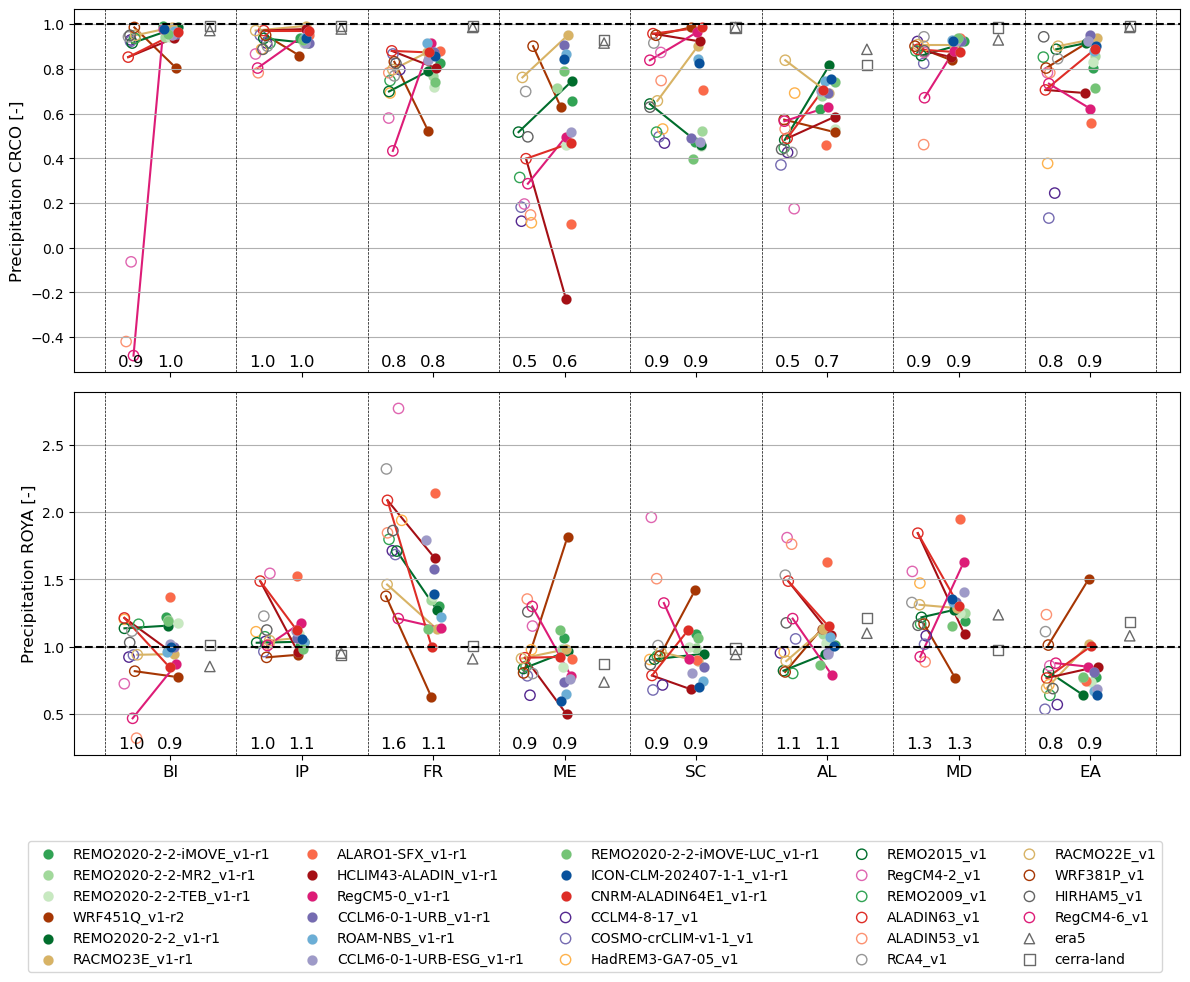

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for n_r, region in enumerate(regions_str): 
    
    df_CMIP6_roya_region = df_CMIP6_roya[df_CMIP6_roya["abbrevs"] == region]
    df_CMIP6_crco_region = df_CMIP6_crco[df_CMIP6_crco["abbrevs"] == region]
    df_CMIP5_roya_region = df_CMIP5_roya[df_CMIP5_roya["abbrevs"] == region]
    df_CMIP5_crco_region = df_CMIP5_crco[df_CMIP5_crco["abbrevs"] == region]
    df_obs_roya_region = df_obs_roya[df_obs_roya["abbrevs"] == region]
    df_obs_crco_region = df_obs_crco[df_obs_crco["abbrevs"] == region]

    df_CMIP5_roya_region["region_shifted"] = (df_CMIP5_roya_region['region']-0.3 
            + np.random.uniform(-0.06, 0.06, size=len(df_CMIP5_roya_region)))
    df_CMIP6_roya_region["region_shifted"] = (df_CMIP6_roya_region['region']
            + np.random.uniform(-0.06, 0.06, size=len(df_CMIP6_roya_region)))
    df_obs_roya_region["region_shifted"] = df_obs_roya_region['region'] + 0.3
                                            
    df_CMIP5_crco_region["region_shifted"] = (df_CMIP5_crco_region['region']-0.3 
            + np.random.uniform(-0.06, 0.06, size=len(df_CMIP5_crco_region)))
    df_CMIP6_crco_region["region_shifted"] = (df_CMIP6_crco_region['region'] 
            + np.random.uniform(-0.06, 0.06, size=len(df_CMIP6_crco_region)))
    df_obs_crco_region["region_shifted"] = df_obs_crco_region['region'] + 0.3

    handles = []
    labels = []
    # crco
    for idx, row in df_CMIP6_crco_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in list_model_version
        color = (
            eur_colors[list_model_version == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[list_model_version == dset_id].apply(
                lambda row: f"{row.parent}_{row.parent_version}", axis=1).values[0]
            if dset_id_in_table
            else None
        )

        scatter = axes[0].scatter(
            row["region_shifted"],
            row['CRCO'],
            color=color,
            edgecolors='lightgray',
            linewidths=0.1,
            facecolor=color,
            marker="o",
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)
            
        if parent is not None:
            row_cmip5 = df_CMIP5_crco_region[df_CMIP5_crco_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["region"] == row.region].iloc[0]
                axes[0].plot(
                    [row_cmip5["region_shifted"], row["region_shifted"]],
                    [row_cmip5['CRCO'], row['CRCO']],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_crco_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in list_model_version
        color = (
            eur_colors[list_model_version == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = axes[0].scatter(
            row["region_shifted"],
            row["CRCO"],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_crco_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            marker = "^"
        elif dset_id in ['cerra', 'cerra-land']:
            marker = "s"
        elif "rocio-ibeb" in dset_id:
            marker = 'X' if region == 'IP' else ''
        scatter = axes[0].scatter(
            row["region_shifted"],
            row["CRCO"],
            color='dimgray',
            edgecolors='dimgray',
            facecolor="none",
            marker=marker,
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    # roya
    for idx, row in df_CMIP6_roya_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in list_model_version
        color = (
            eur_colors[list_model_version == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[list_model_version == dset_id].apply(
                lambda row: f"{row.parent}_{row.parent_version}", axis=1).values[0]
            if dset_id_in_table
            else None
        )

        scatter = axes[1].scatter(
            row["region_shifted"],
            row['ROYA'],
            color=color,
            edgecolors='lightgray',
            linewidths=0.1,
            facecolor=color,
            marker="o",
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)
            
        if parent is not None:
            row_cmip5 = df_CMIP5_roya_region[df_CMIP5_roya_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["region"] == row.region].iloc[0]
                axes[1].plot(
                    [row_cmip5["region_shifted"], row["region_shifted"]],
                    [row_cmip5['ROYA'], row['ROYA']],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_roya_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in list_model_version
        color = (
            eur_colors[list_model_version == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = axes[1].scatter(
            row["region_shifted"],
            row["ROYA"],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_roya_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            marker = "^"
        elif dset_id in ['cerra', 'cerra-land']:
            marker = "s"
        elif "rocio-ibeb" in dset_id:
            marker = 'X' if region == 'IP' else ''
        scatter = axes[1].scatter(
            row["region_shifted"],
            row["ROYA"],
            color='dimgray',
            edgecolors='dimgray',
            facecolor="none",
            marker=marker,
            s=55,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)


for n_a in [0, 1]:
    axes[n_a].grid(True, axis = 'y')
    axes[n_a].axhline(1, color="k", linestyle="--")
    for v in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]:
        axes[n_a].axvline(v, color="k", linestyle="--", linewidth = 0.5)

    if n_a == 0:
        axes[n_a].set_ylabel(f"{variable} CRCO [-]", fontsize = 12)
    elif n_a == 1:
        axes[n_a].set_ylabel(f"{variable} ROYA [-]", fontsize = 12)

axes[1].set_xticks(np.arange(len(regions_str))+1)  # Adjust tick positions according to the shift
axes[1].set_xticklabels(regions_str, fontsize = 12)  # Set the names of the seasons as labels


# Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
for j, region in enumerate(regions_str):
    def select_by_region(df, region, variable):
        return df[variable].loc[
            (df["abbrevs"] == region)]
    cmip6_median_CRCO = np.nanmedian(abs(select_by_region(df_CMIP6_CRCO_fair, region, "CRCO")))
    cmip5_median_CRCO = np.nanmedian(abs(select_by_region(df_CMIP5_CRCO_fair, region, "CRCO")))
    cmip6_median_ROYA = np.nanmedian(abs(select_by_region(df_CMIP6_ROYA_fair, region, "ROYA")))
    cmip5_median_ROYA = np.nanmedian(abs(select_by_region(df_CMIP5_ROYA_fair, region, "ROYA")))

    for n_m, mm in enumerate(["CRCO", "ROYA"]):

        if  mm in "CRCO":
            texts = [cmip5_median_CRCO, cmip6_median_CRCO]
        elif mm in "ROYA":
            texts = [cmip5_median_ROYA, cmip6_median_ROYA]

        positions = [-0.3, 0]        
        for text, position in zip(texts, positions): 
            # Add the absolute median bias text below the season labels
            axes[n_m].text(
                j + 1 + position,
                0.008,
                f"{text:.1f}",
                fontsize=12,
                verticalalignment="bottom",
                horizontalalignment="center",
                color="black",
                transform=axes[n_m].get_xaxis_transform(),  # y in axes coords, x in data coords
        )

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)

plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_annual_cycle_{index}_both_periods.png",
    bbox_inches="tight",
    transparent=True,
)
fig.savefig(
    f"{save_figure_path}/{reference_regions}_annual_cycle_{index}_both_periods.pdf",
    bbox_inches="tight",
    transparent=True,
)